In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import yaml
import sys 
sys.path.append('..')

from ptsemseg.loader import get_loader
from ptsemseg.loader import get_loader
from ptsemseg.models import get_model
from ptsemseg.utils import get_model_state
import matplotlib.pyplot as plt
import matplotlib
import patch_utils as patch_utils
from torch.utils import data
import numpy as np
from torch import nn
from PIL import Image
import torch
import os

from IPython.display import display # to display images

print('torch version:       {}'.format(torch.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

[autoreload of ptsemseg.loader.pascal_voc_loader failed: Traceback (most recent call last):
  File "/home/g.rossolini/venv/RWs_SS/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/g.rossolini/venv/RWs_SS/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/g.rossolini/venv/RWs_SS/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/g.rossolini/venv/RWs_SS/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/g.rossolini/venv/RWs_SS/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/g.rossolini/venv/RWs_SS/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, 

torch version:       1.10.1+cu111
numpy version:       1.18.0
matplotlib version:  3.3.4
CUDA available:      True
cuDNN enabled:       True
num gpus:            8


In [12]:
config_path = 'bisenet_dyn_600.yml'

with open(config_path) as fp:
    cfg = yaml.load(fp)

model_file_name = os.path.split(cfg["model"]["path"])[1]
model_name = model_file_name[: model_file_name.find("_")]

device = torch.device("cuda")
torch.cuda.set_device(cfg["device"]["gpu"])

# Setup Dataloader
data_loader = get_loader(cfg["data"]["dataset"])
data_path = cfg["data"]["path"]
cfg_patch_opt = cfg['adv_patch']['optimization']

train_loader = data_loader(
    data_path,
    is_transform=True,
    split=cfg["data"]["train_split"],
    version= cfg["data"]["version"],
    img_size=(cfg["data"]["img_rows"], cfg["data"]["img_cols"]),
    img_norm = cfg["data"]["img_norm"],
    bgr = cfg["data"]["bgr"],
    std_version = cfg["data"]["std_version"]
    )

validation_loader = data_loader(
    data_path,
    is_transform=True,
    split=cfg["data"]["val_split"],
    version= cfg["data"]["version"],
    img_size=(cfg["data"]["img_rows"], cfg["data"]["img_cols"]),
    img_norm = cfg["data"]["img_norm"],
    bgr = cfg["data"]["bgr"], 
    std_version = cfg["data"]["std_version"],
    bottom_crop = 0
    )


n_classes = train_loader.n_classes
#if num_train_samples is not None:
mean_std_loader, calibration_loader,_ = torch.utils.data.random_split(
    train_loader, 
    [500, 50, len(train_loader)-550])
    
n_classes = train_loader.n_classes


calibrationloader = data.DataLoader(
    calibration_loader, 
    batch_size=5, 
    num_workers=cfg["device"]["n_workers"],
    shuffle=False
)


validationloader = data.DataLoader(
    validation_loader, 
    batch_size=5, 
    num_workers=cfg["device"]["n_workers"],
    shuffle=False
)


/home/g.rossolini/venv/RWs_SS/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
model_dict = {"arch": cfg["model"]["arch"]}
model = get_model(model_dict, n_classes, version=cfg["data"]["dataset"])
state = torch.load(cfg["model"]["path"], map_location = 'cpu')
state = get_model_state(state, model_name)
model.load_state_dict(state, strict=False)

model = model.eval()

bisenetX39


In [ ]:

import zmask_tool as zmask_tool


cntx_layer = {
    #'log_ct0': model.log_ct0,
    'log_ct1': model.log_ct1,
    'log_ct2': model.log_ct2,
    'spatial_path2': model.spatial_path.conv_1x1,
    'spatial_path1': model.spatial_path.conv_7x7
}

spt_layer = {
    'spatial_path2': model.spatial_path.conv_1x1,
    'spatial_path1': model.spatial_path.conv_7x7,
    'log_ct2': model.log_ct2
}

layers = dict(list(cntx_layer.items()) + list(spt_layer.items()))
kernel_cntx = [(64,128), (32, 64)]
kernel_sp = [(64,128), (32,64), (16,32), (8,16)]
size_fig = (150,300)
num_planes = 1



In [ ]:
#Test activation fetching.
import zmask_utils
import patch_utils as patch_utils
from torch import optim
from torch import autograd

In [ ]:
patch_path = 'patches/patch_final_10.png'
if patch_path is None:
    patch = patch_utils.get_random_patch(cfg["adv_patch"]["attr"], set_loader=train_loader)
else:
    patch = patch_utils.get_patch_from_img(patch_path, set_loader=train_loader)
patch_utils.init_model_patch(model = model, mode = "test", seed_patch = patch)
  

# patch position (and base position for EOT) 
patch_x, patch_y = cfg['adv_patch']['attr']['pos_x'], cfg['adv_patch']['attr']['pos_y']
if(patch_x is None or patch_y is None):
    patch_x = int((train_loader.img_size[1]- patch.size(3))/2) + 0
    patch_y = int((train_loader.img_size[0] - patch.size(2))/2) + 0
    
patch_params = patch_utils.patch_params(
    x_default = patch_x, 
    y_default = patch_y,
    set_loader = train_loader,
    use_transformations = True,
    eps_x_translation = 1.0, 
    eps_y_translation = 1.0,
    max_scaling = 1.2, 
    min_scaling = 0.9)

In [ ]:
import random

model = model.eval() 
model = model.to(device)

ZMASK = zmask_tool.ZMASK(spt_layer, kernel_sp, cntx_layer, kernel_cntx, device, size_fig, num_planes)
std_layers, mean_layers = ZMASK.compute_mean_and_std(model=model, loader=mean_std_loader)

In [ ]:
import torch.nn.functional as F

tot_heat_array = []

min_patch_level = 4
max_patch_level = 6

count_images = 0

for (images, labels) in calibrationloader:
    
    images = images.to(device)
    idx = random.randint(min_patch_level,max_patch_level)
    for idx in range(min_patch_level, max_patch_level):
    
        patch_path = 'patches/patch_final_'+str(idx)+'0.png'
        if patch_path is None:
            patch = patch_utils.get_random_patch(cfg["adv_patch"]["attr"], set_loader=train_loader)
        else:
            patch = patch_utils.get_patch_from_img(patch_path, set_loader=train_loader)
        patch_utils.init_model_patch(model = model, mode = "test", seed_patch = patch)
        model = model.to(device)
        
        perturbed_images, patch_masks = patch_utils.add_patch_to_batch(
                            images = images.clone(), 
                            patch = model.patch, 
                            patch_params = patch_params,
                            device = device, 
                            int_filtering=False)

        acts = zmask_utils.get_activations(model, layers, perturbed_images)
        tot_context_heat, tot_spatial_heat  = ZMASK.run_analysis(acts)
        
        tot_context_heat = tot_context_heat.detach().cpu()
        tot_spatial_heat = tot_spatial_heat.detach().cpu()
        patch_masks = F.interpolate(patch_masks, size=tot_spatial_heat.shape[2:])
        patch_masks = patch_masks.detach().cpu()
        
        for i in range(tot_context_heat.shape[0]):
            tot_heat_array.append([tot_context_heat[i],tot_spatial_heat[i], patch_masks[i], idx])
    
    count_images += 1
    if count_images % 10 == 0:
        print("heatmaps saved: " + str(count_images))

/home/g.rossolini/git/zmask_demo/zmask_tool.py:275: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  heat = torch.tensor(heat).to('cuda')


heatmaps saved: 10


In [ ]:
import random
random.shuffle(tot_heat_array)
batch_context_heat_array = []
batch_spatial_heat_array = []

In [ ]:
optimizer =torch.optim.Adam([
                {'params': ZMASK.DefenseBlock.MaskBlock.parameters()}
            ], lr=0.01)

batch_size = 15
ZMASK.DefenseBlock = ZMASK.DefenseBlock.to(device)
ZMASK.DefenseBlock = ZMASK.DefenseBlock.train()

ZMASK.DefenseBlock.MaskBlock.init_weights()
training_epochs = 250
count = 0
    
    
while count < training_epochs:
    
    epoch_loss = 0
    epoch_loss_mask = 0
    num_samples = 0
    
    def batch_above_min(tot_heat_array, batch_size, i):
        batch_array = [ [], [], [] ]
        for val in tot_heat_array[(i*batch_size):(i*batch_size)+batch_size]:
            if val[3] >= min_patch_level:
                batch_array[0].append(val[0].unsqueeze(0))
                batch_array[1].append(val[1].unsqueeze(0))
                batch_array[2].append(val[2].unsqueeze(0))
        return batch_array
        

    for i in range(int(len(tot_heat_array)/batch_size)):
        batch_array = batch_above_min(tot_heat_array, batch_size, i)
        batch_context = torch.cat(batch_array[0]).to(device)
        batch_spatial = torch.cat(batch_array[1]).to(device)
        batch_mask_gt = torch.cat(batch_array[2]).to(device)    
        images = images.to(device)
        optimizer.zero_grad()
        flag, output_mask  = ZMASK.DefenseBlock(batch_context, batch_spatial)
        loss_mask = zmask_tool.binary_cross_entropy2d(input=output_mask, target=batch_mask_gt.to(device))
        epoch_loss_mask += loss_mask.item()

        loss_mask.backward(retain_graph=True)
        optimizer.step()
        num_samples += batch_context.shape[0]
    
    count += 1
    if count % 10 == 0:
        print("loss mask" + epoch_loss_mask)

ZMASK.DefenseBlock = ZMASK.DefenseBlock.eval()

TypeError: must be str, not float

In [ ]:
torch.save(ZMASK.DefenseBlock.state_dict(), "./ZMASK_bisenet_cityscapes_demo.pth")

In [ ]:
ZMASK.DefenseBlock.load_state_dict(torch.load("./ZMASK_bisenet_cityscapes_demo.pth"))
ZMASK.DefenseBlock = ZMASK.DefenseBlock.eval()

In [ ]:
patch_path = 'patches/patch_final_100.png'

if patch_path is None:
    patch = patch_utils.get_random_patch(cfg["adv_patch"]["attr"], set_loader=train_loader)
else:
    patch = patch_utils.get_patch_from_img(patch_path, set_loader=train_loader)
patch_utils.init_model_patch(model = model, mode = "test", seed_patch = patch)

model = model.to(device)
  


# patch position (and base position for EOT) 
patch_x, patch_y = cfg['adv_patch']['attr']['pos_x'], cfg['adv_patch']['attr']['pos_y']
if(patch_x is None or patch_y is None):
    patch_x = int((train_loader.img_size[1]- patch.size(3))/2) + 0
    patch_y = int((train_loader.img_size[0] - patch.size(2))/2) + 0
    
patch_params = patch_utils.patch_params(
    x_default = patch_x, 
    y_default = patch_y,
    set_loader = train_loader,
    use_transformations = False,
    eps_x_translation = 1.0, 
    eps_y_translation = 1.0,
    max_scaling = 1.2, 
    min_scaling = 0.9)

In [ ]:
ZMASK.context_layer.keys()

dict_keys(['log_ct1', 'log_ct2', 'spatial_path2', 'spatial_path1'])

/home/g.rossolini/git/zmask_demo/zmask_tool.py:275: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  heat = torch.tensor(heat).to('cuda')


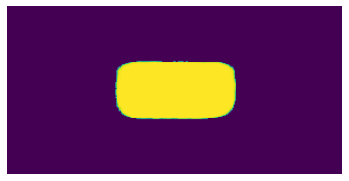

In [ ]:
#images = validation_loader[23][0].unsqueeze(0).to(device)

#-------------------------------------------------------------
# let's use a test image instead rather than one from the validation set. 
from PIL import Image
from torchvision import models, transforms
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.Resize((1024, 2048)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

# Load the image
image_path = './images/test_image.jpg' 
images = Image.open(image_path)
images = transform(images)
images = images.unsqueeze(0).cuda()


ZMASK.DefenseBlock = ZMASK.DefenseBlock.eval()
ZMASK.DefenseBlock = ZMASK.DefenseBlock.to(device)

perturbed_images, patch_masks = patch_utils.add_patch_to_batch(
                            images = images.clone(), 
                            patch = model.patch, 
                            patch_params = patch_params,
                            device = device, 
                            int_filtering=True)

acts = zmask_utils.get_activations(model, layers,perturbed_images)
model = model.to(device)
tot_context_heat,tot_spatial_heat = ZMASK.run_analysis(acts)
        
flag, output_mask  = ZMASK.DefenseBlock.forward(tot_context_heat, tot_spatial_heat)        
output_mask = output_mask.squeeze(0).squeeze(0).detach().cpu().numpy()
output_mask[output_mask < 0.5] = 0.0
plt.axis('off')
plt.imshow(output_mask)

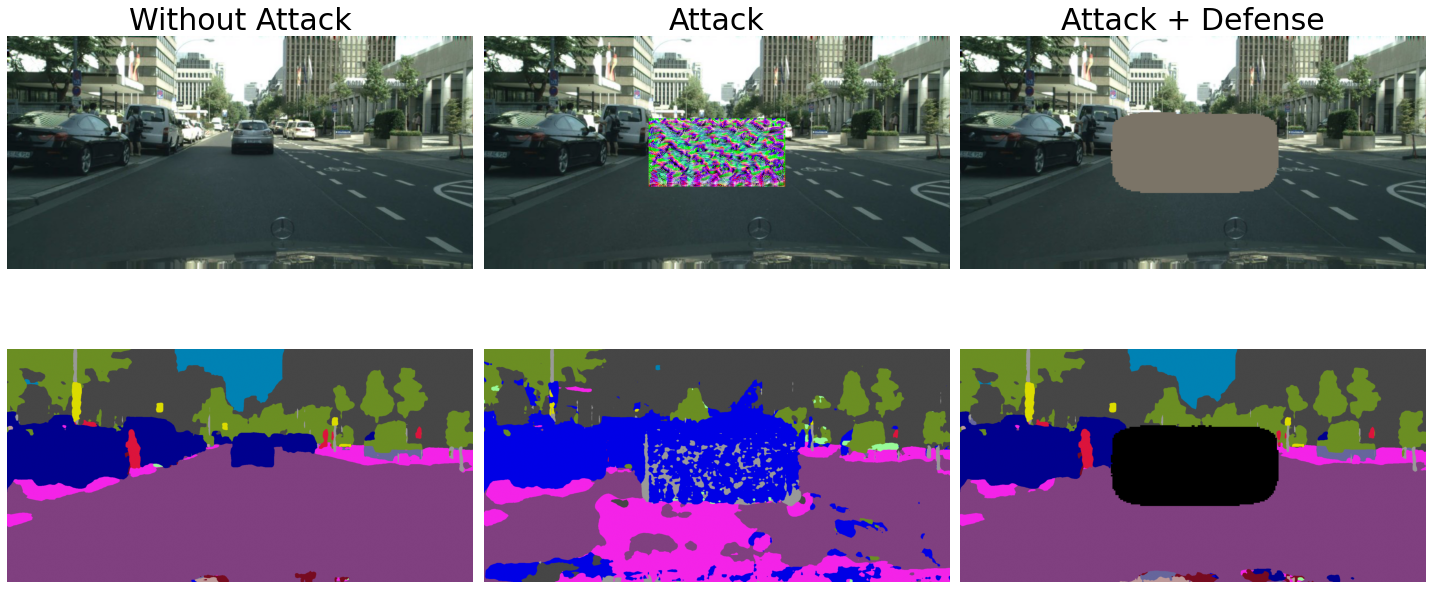

In [ ]:
import torch.nn.functional as F

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

axs[0,0].axis('off')
axs[0, 0].imshow(patch_utils.convert_tensor_image(images, set_loader=train_loader))
axs[0, 0].set_title('Without Attack', fontsize=30)

axs[0,1].axis('off')
axs[0,1].imshow(patch_utils.convert_tensor_image(perturbed_images, set_loader=train_loader))
axs[0,1].set_title('Attack', fontsize=30)

flag, output_mask  = ZMASK.DefenseBlock.forward(tot_context_heat, tot_spatial_heat)
output_mask[output_mask < 0.5] = 0.0
output_mask[output_mask > 0.5] = 1.0
output_mask = F.interpolate(output_mask, size=perturbed_images.shape[2:])
axs[0,2].axis('off')
axs[0,2].imshow(patch_utils.convert_tensor_image(perturbed_images*(1-output_mask), set_loader=train_loader))
axs[0,2].set_title('Attack + Defense', fontsize=30)

axs[1,0].axis('off')
axs[1,0].imshow(patch_utils.convert_tensor_SS_image(
    model(images.to(device)), 
    model_name = model_name, 
    orig_size =(cfg["data"]["img_rows"], cfg["data"]["img_cols"]), 
    set_loader = train_loader))

axs[1,1].axis('off')
axs[1,1].imshow(patch_utils.convert_tensor_SS_image(
    model(perturbed_images.to(device)), 
    model_name = model_name, 
    orig_size =(cfg["data"]["img_rows"], cfg["data"]["img_cols"]), 
    set_loader = train_loader))

axs[1,2].axis('off')
axs[1,2].imshow(patch_utils.convert_tensor_SS_image(
    model(perturbed_images*(1-output_mask).to(device)), 
    model_name = model_name, 
    orig_size =(cfg["data"]["img_rows"], cfg["data"]["img_cols"]), 
    set_loader = train_loader)*(1-output_mask).detach().squeeze(1).cpu().numpy().transpose(1,2,0))



# Adjust layout
plt.tight_layout()
plt.show()